< [Part 4: Social Features](spotify_4_popularity_and_followers.ipynb) | [Main](index.ipynb) |

---

# Classifying Tracks using Audio Features

In previous notebooks, we [**scraped a large number of tracks**](spotify_1_scraping.ipynb) from both my personal Spotify library and the Billboard Hot 100 from every year since 1960. We analyzed how these tracks vary between the two datasets, exploring [**basic features**](spotify_2_basic_exploration.ipynb) such as release dates and genres, [**audio features**](spotify_3_audio_features.ipynb) such as tempo and loudness, and [**social features**](spotify_4_popularity_and_followers.ipynb) such as artist popularity and the number of followers an artist has. 

---

Now that we've thoroughly explored our datasets' features, we're ready to build a classifier. Our classifier will attempt to determine whether a given track came from my library (`'nix'`) or the Billboard dataset (`'top'`), and will do so using *only audio features*. Once we've built our classifier, we'll use it to build a simple recommender to suggest new tracks that I might like.

We'll later see how including other features such as artist popularity or release year gives models with significantly higher cross-validated scores on our data but:

- Including these additional features leads to a model that is overfit to some of the "particulars" of the training data, despite cross-validation. This causes the resulting recommender system to give useless recommendations (e.g. suggesting that I will like a track simply because it is *unpopular*).

- We are interested in determining how much predictive power the audio has *in isolation* (via Spotify's precalculated audio features), with no additional metadata or cultural information. 

---

We'll start with simple, interpretable models that will allow us to further understand our data. We'll then work up to more powerful, complex models.

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import Image, display, HTML

#ML
import sklearn
from sklearn.base import clone
#Replace recall_score with balanced_accuracy_score when new sklearn released
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import ( RepeatedStratifiedKFold, GridSearchCV, 
                                     cross_validate )
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import eli5
from eli5.sklearn import PermutationImportance

#Collection of functions created in previous notebook
from spotify_auth import *
from scrape_playlist_dataframe import *
from groupby_lists import *

#Load Spotify API keys
from keys import *

%matplotlib inline

#Custom seaborn/matplotlib settings
rc = {'axes.edgecolor': '0', 'axes.labelcolor': '0', 'grid.color': '0', 
      'figure.figsize': [6, 6], 'lines.linewidth': '2', 'text.color': '0', 
      'xtick.color': '0', 'ytick.color': '0' }
sns.set(context='notebook', style='white', font_scale=1.5, rc=rc)

pd.options.display.max_columns = 50

red = (1,0,0)
blue = (0,.475,1) #Same relative luminance (linearized) as primary red (approx)
purple = (.736,.343,.736) #Linearized average between above red and blue

df = pd.read_hdf('./data/df.h5', 'main')

## Model Performance Metrics

When quantifying the performance of each model, we will be primarly concerned with four metrics:

- **Recall** (`'nix'`): The fraction of tracks from *my library* that the model correctly classifies as having come from my library. If tracks from my library are treated as "positive" samples, this is also known as the **sensitivity**. In that context, sensitivity is *also* known as simply **recall** (no label specified). Our recalls defined here are a more general *multi-class* notion of recall where the positive class is specified explicitly. See e.g. [scikit-learn's `recall_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) with `average='binary'` and either `pos_label=0` or `pos_label=1`.

- **Recall** (`'top'`): The fraction of tracks from the *Billboard dataset* that the model correctly classifies as having come from the Billboard dataset. If tracks from the Billboard dataset are treated as "negative" samples, this is also known as the **specificity**.

- **Accuracy**: The fraction of tracks from *either dataset* that the model correctly classifies. This is a straightforward and useful metric, but may give undesirable results when our classes are imbalanced.

- **(Class-)Balanced Accuracy**: The unweighted average of the two recalls above. Also known as **Macro-average Recall**.

Let's try to understand why the macro average recall is a measure of class-balanced accuracy. Accuracy itself can be calculated as a *weighted* average of the two recalls above. Using "negative", "positive", "correct", "TN", "TP", and "total" to indicate the *number* of negative samples, positive samples, correctly classified samples, true negatives, true positives, and total samples (respectively) we have:

\begin{alignat*}{2}
\text{accuracy}=
\frac{ \text{correct} }{ \text{total} } =\; 
\frac{ \text{TN}+\text{TP} }{ \text{total} } 
=& \hspace{34pt} \frac{ \text{TN} }{ \text{total} } &&+ \hspace{30pt} \frac{ \text{TP} }{ \text{total} } \\[10pt]
=& \hspace{7pt} \frac{ \text{TN} }{ \text{negative} } \cdot \frac{ \text{negative} }{ \text{total} } &&+ \hspace{5pt} \frac{ \text{TP} }{ \text{positive} } \cdot \frac{ \text{positive} }{ \text{total} } \\[10pt]
=& \, \text{specificity} \hspace{1pt} \cdot \text{%negative} \hspace{2pt} &&+ \text{sensitivity} \cdot \text{%positive}.
\end{alignat*}

So we have that the accuracy is the weighted average of specificity and sensitivity, where the weights on each are the fraction of negative ($\text{%negative}$) or positive ($\text{%negative}$) samples respectively. When there is an equal number of positive and negative samples, these weights will both equal $1/2$. This suggests a natural way to effectively *force* the accuracy to consider each class equally regardless of class imbalance: Explicitly replace each weight with $1/2$. This gives us precisely the macro average recall defined above:

$$\text{macro-average recall} = \; \frac{ \text{specificity} + \text{sensitivity} }{2}.$$

This metric is implemented in [scikit-learn as `recall_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html) with `average='macro'`. It is also implemented in [scikit-learn as `balanced_accuracy_score`](http://scikit-learn.org/dev/modules/generated/sklearn.metrics.balanced_accuracy_score.html), which is only available in the *development* version of scikit-learn as of this writing.

It is also worth noting that when doing binary classification with a *fixed decision threshold*, **macro-average recall is identical to [ROC AUC](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)**. This is the case when using a *non-probabilistic classifier* (i.e. no `.predict_proba` method) or a *fixed list of predictions*.

## Cross-Validated Grid Search and Model Performance

For each model class, we'll find optimal values for the model hyperparameters by using a cross-validated **grid search**. 

We may obtain better results by using randomized search, or more intelligent (e.g. Bayesian, Gaussian process) optimization methods, but grid search will suffice for the minimal adjustments we'll make. It also allows us to control the hyperparameter space in a simple, precise way. We'll optimize the cross-validated **macro-average recall**, which &mdash; as discussed above &mdash; is similar to AUC ROC in general, and *identical* to AUC ROC for deterministic, binary classification.

We'll use **5x5-fold repeated stratified cross-validation** to give an estimate of generalization performance. This is simply 5 repeats of 5-fold cross-validation, with shuffling between each repeat. These repeats decrease the variance of the average performance score, and *slightly* decrease the score's bias. Stratification ensures that each split gives representative ratios of the two classes (`'nix'` and `'top'`). 

Once optimal hyperparameters are found, the model class is re-fit on the entire dataset, giving our optimal model.

We'll then display the resulting model's generalization performance by plotting the four metrics above (recall on each class label, accuracy, and macro-average recall), again with 5x5-fold cross-validation. We *could* obtain these scores during grid search. Instead, we'll create a separate function that makes a copy of any given model (really, a model *class* with a particular set of hyperparameters), and calculates its cross-validated performance scores. This gives the same results as the grid search would (up to random variation), and lets us separate evaluation and plotting from hyperparameter optimization. By doing so, we don't need to include all four metrics in our grid search, and we can calculate cross-validated scores even for models where we aren't optimizing hyperparameters (e.g. a full-depth decision tree).

## Plotting and Other Helper Functions: df_to_Xy, rskfold_gridsearch, and model_score_plot

Since splitting a dataframe into arrays of features (`X`) and labels (`y`) is so common, let's wrap the procedure up into a helper function `df_to_Xy`, specific to our `'nix'` and `'top'` class labels.

In [2]:
def df_to_Xy(df, cols):
    #Non-missing features and labels
    X = df[ cols+['ds'] ].dropna().copy()
    
    #Just labels
    y = X['ds'].copy()
    
    #Just features
    X = X.drop('ds', axis=1)
    
    #A few sklearn functions will break if labels are not integers.
    y = y.map( {'nix':1, 'top':0} )
    
    return X,y

Now, let's define a function &mdash; `rskfold_gridsearch` &mdash; that performs repeated stratified k-fold cross-validated grid search on a model.

In [3]:
def rskfold_gridsearch(X, y, model_class, param_grid, n_splits=5, n_repeats=5, 
                       scoring='recall_macro', verbose=1):
    #Initialize GridsearchCV with cross-validation object
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    grid = GridSearchCV(model_class, param_grid=param_grid, cv=cv, 
                        scoring=scoring, verbose=verbose, n_jobs=-1)
    
    #Fit grid to data
    grid.fit(X,y)
    print( 'Best parameters: {}'.format(grid.best_params_) )
    
    #Return best estimator, already re-fit on the full training set.
    return grid.best_estimator_

Finally, let's define our function for plotting model performance. As discussed above, we'll plot the recall for each class (`'nix'` in **blue** and `'top'` in **red**), as well as the accuracy and balanced accuracy (both in **purple**).

In [4]:
def model_score_plot(model, X, y, n_splits=5, n_repeats=5, model_name=''):
    """
    Plots model recall for each class, as well as accuracy and 
    balanced accuracy, averaged over 'n_repeats' repeats of 'n_splits' folds.
    """
    
    #To avoid side effects in original model.
    mdl = clone(model)
    
    #Create cross-validation object
    rskfold = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)

    #The first scorer here is actually the default recall score, so we could 
    #just use 'recall' string as scorer. Doing it this way makes the 
    #distinction between the two recalls clearer.
    recall_nix_scorer = make_scorer(recall_score, pos_label=1)
    recall_top_scorer = make_scorer(recall_score, pos_label=0)

    #Calculated all four cross-validated scores
    scores = cross_validate(mdl, X, y, return_train_score=False, cv=rskfold,
                             scoring={'recall_nix':recall_nix_scorer, 
                                      'recall_top':recall_top_scorer, 
                                      'accuracy':'accuracy', 
                                      'balanced_accuracy':'recall_macro'},
                            n_jobs=-1)
    
    #Average scores over the validation sets
    recall_nix = scores['test_recall_nix'].mean()
    recall_top = scores['test_recall_top'].mean()
    accuracy = scores['test_accuracy'].mean()
    balanced_accuracy = scores['test_balanced_accuracy'].mean()

    #Build up plot with three separate seaborn barplots.
    plt.figure(figsize=(5,5))
    #Background bars:
    p = sns.barplot(x=(1, 1, 1, 1), y=('Nix','Top','Total','Balanced'), 
                    palette=[ red, blue, (1,1,1), (1,1,1) ], 
                    saturation=1, linewidth=0 )
    #Foreground bars:
    p = sns.barplot(x=(recall_nix, recall_top, accuracy, balanced_accuracy), 
                    y=('Nix','Top','Total','Balanced'), 
                    palette=[blue, red, purple, purple], 
                    saturation=1, linewidth=0 )
    #Outline bars (simpler than tweaking above barplots' outlines)
    p = sns.barplot(x=(1, 1, 1, 1), y=('Nix','Top','Total','Balanced'),
                    saturation=1, linewidth=2, fill=False,
                    edgecolor=[(0,0,0),(0,0,0),(0,0,0),(0,0,0)] )
    
    #Formatting tweaks
    sns.despine(left=True, bottom=True)
    p.set_xticklabels([])
    p.tick_params(labelsize=20)
    
    #Colored labels
    p.yaxis.get_ticklabels()[0].set_color(blue)
    p.yaxis.get_ticklabels()[1].set_color(red)
    p.yaxis.get_ticklabels()[2].set_color(purple)
    p.yaxis.get_ticklabels()[3].set_color(purple)

    
    #Overlay labels and % values on each bar
    descriptors = ['Recall', 'Recall', 
                   'Accuracy', 'Balanced Accuracy']
    for i,patch in enumerate( p.patches[4:8] ):
        width = patch.get_width()
        yloc = patch.get_y() + patch.get_height()/2
        label = '{:1.1f}%\n'.format(width*100) + descriptors[i]
        p.text( width/2 , yloc, label, ha='center', va='center', color=(1,1,1),
              weight='bold', fontsize=18)
    
    #Construct title.
    #Add newline if model_name is provided.
    if model_name is not '':
        model_name += '\n'
    title = model_name + '{}x{}-Fold Scores'.format(n_repeats, n_splits)    
    p.set_title(title)

    #Prevents bar edge clipping.
    p.set_xlim([-.01,1.01])
    
    return p

Let's prepare our datasets for classification using our `df_to_Xy` function. As stated above, we'll only use a track's *audio features*.

In [5]:
cols_audio = ['acousticness', 'danceability', 'duration_mins', 'energy', 
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence']

X,y = df_to_Xy(df, cols_audio)

In [6]:
X.sample(5)

,acousticness,danceability,duration_mins,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
10417,0.3880,0.518,4.054883,0.263,0.000003,8.0,0.0685,-19.619,1.0,0.0269,86.145,4.0,0.542
5113,0.0806,0.603,5.014450,0.939,0.615000,1.0,0.1050,-14.002,1.0,0.0539,109.075,4.0,0.641
38,0.6900,0.339,4.136883,0.830,0.970000,4.0,0.1140,-6.073,1.0,0.0343,129.014,4.0,0.311
3069,0.1050,0.333,22.784883,0.497,0.872000,2.0,0.1290,-15.606,1.0,0.0366,81.681,4.0,0.113
8571,0.5220,0.769,5.072667,0.534,0.000000,8.0,0.0570,-6.096,0.0,0.0468,81.729,4.0,0.895


In [7]:
y.sample(5)

8406    0
2049    1
8231    0
1246    1
9453    0
Name: ds, dtype: int64

Looks good! Let's build some classifiers!

## Logistic Regression

We'll start with a simple, interpretable logistic regression model.

Fitting 25 folds for each of 40 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   53.5s
[Parallel(n_jobs=-1)]: Done 289 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 789 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 989 out of 1000 | elapsed:  1.7min remaining:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.7min finished


Best parameters: {'C': 0.077793286841501469, 'penalty': 'l1'}


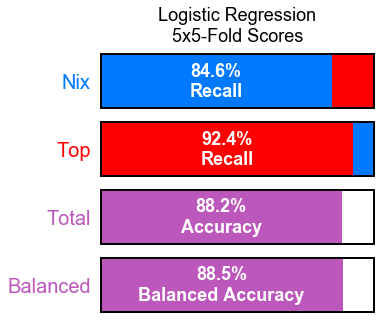

In [42]:
param_grid = {'C': 2**np.linspace(-10, 10, 20),
              'penalty': ['l1','l2']}
model_class = LogisticRegression()
best_logistic = rskfold_gridsearch(X, y, model_class, param_grid)

p = model_score_plot(best_logistic, X, y, model_name='Logistic Regression')

#89% balacc
#{'C': 0.077793286841501469, 'penalty': 'l1'}

This isn't bad for such a simple model. Let's visualize the model's coefficients as a bar chart, sorted by magnitude:

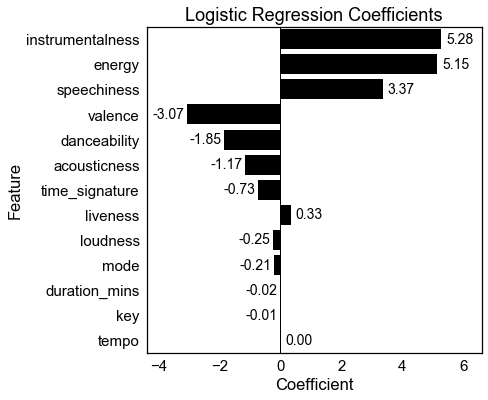

In [14]:
#Create dataframe of feature names and corresponding regression coefficients
features = X.columns
coefs = best_logistic.coef_[0]
df_coefs = pd.DataFrame( list( zip(features,coefs) ), 
                        columns=['Feature','Coefficient'] )

#Temporarily construct magnitudes and sort by them
df_coefs['Magnitude'] = df_coefs.Coefficient.abs()
df_coefs.sort_values(by='Magnitude', inplace=True, ascending=False)
df_coefs.drop('Magnitude', axis=1, inplace=True)
df_coefs.reset_index(inplace=True)

#Make bar plot
p = sns.barplot(x='Coefficient', y='Feature', data=df_coefs, color=(0,0,0))

#Add labels to each bar showing actual coefficient value
label_width = 0.6
for i,patch in enumerate(p.patches):
    xloc = patch.get_width()
    xsign = np.sign( patch.get_width() ) 
    yloc = patch.get_y() + patch.get_height()/2
    coeff = df_coefs['Coefficient'][i]
    label = '{:1.2f}'.format(coeff)
    p.text( xloc + xsign*label_width , yloc, label, ha='center', 
           va='center', size=14)

#Tweak plot scaling. Add vertical line and title
ymin,ymax = p.get_ylim()
xmin,xmax = p.get_xlim()
p.set_xlim( [xmin - label_width -.3, xmax + label_width +.3] )
p.vlines(0, ymin=ymin, ymax=ymax, lw=1)
p.set_title('Logistic Regression Coefficients');

The coefficients shown here represent *log odds ratios*. In our particular problem, the odds we are interested in is 

$$\text{Odds}(\text{dataset='nix'}) = \frac{ P(\text{dataset='nix'}) }{ P(\text{dataset='top'}) }.$$

Specifically, we would like to know how these odds change when we change the value of one of our features (while holding the others constant). To make this a bit more well-defined, let's say that we want to know how these odds change when we *increase the value of a given feature by $1$*. 

Consider, for example, the `'valence'` feature. When `'valence'=0`, we have the following odds:

$$\text{Odds}(\text{dataset='nix'}|\text{valence=0}) = \frac{ P(\text{dataset='nix'}|\text{valence=0}) }{ P(\text{dataset='top'}|\text{valence=0}) }.$$

Similarly, when `'valence'=1`, we have:

$$\text{Odds}(\text{dataset='nix'}|\text{valence=1}) = \frac{ P(\text{dataset='nix'}|\text{valence=1}) }{ P(\text{dataset='top'}|\text{valence=1}) }.$$

We can compare these odds by simply taking their ratio, giving us the *odds ratio*

$$\frac{ \text{Odds}(\text{dataset='nix'}|\text{valence=1}) }{ \text{Odds}(\text{dataset='nix'}|\text{valence=0}) }.$$

Again, this tells us how much the odds of a track coming from the `'nix'` dataset increases when we increase `'valence'` by $1$ (holding other features fixed). 

The logistic regression coefficients are simply the *natural logarithm* of these odds ratios. A *large negative* coefficient therefore indicates that the odds of a track coming from the `'nix'` dataset *greatly decreases* as we increase the corresponding feature. Likewise, a *large positive* coefficient indicates a *large increase* in the odds that a track came from the `'nix'` dataset. Coefficients with *small magnitude* correspond to features that have *little effect* on the odds, indicating that they have little predictive power (in a linear sense). We can also obtain the actual odds ratios by *exponentiating* the logistic coefficients.

---

The top coefficients are those corresponding to the features `'instrumentalness'`, `'energy'`, and `'speech'`, indicating that **tracks that are *more instrumental*, *higher energy*, and *higher in speechiness* are *much more likely to be classified as having come from my library*.** For example, the largest coefficient is $5.28$ and corresponds to `'instrumentalness'`. Exponentiating this coefficient gives $e^{5.28} \approx 200$ which indicates that **the odds of a track being classified as `'nix'` increases by a factor of around $200$ as `'instrumentalness'` increases from `0` to `1`.** The next top three coefficients are all *negative*, indicating that **tracks with *lower* valence, *lower* danceability, and *lower* acousticness are more likely to be classified as having come from my library.** This all lines up with observations made in my [previous notebook](spotify_3_audio_features.ipynb).

The smallest coefficients correspond to `'duration_mins'`, `'key'`, and `'tempo'`. Both `'duration_mins'` and `'tempo'` have averages that are nearly identical in both datasets, but my dataset has more tracks that are extremely fast (or slow) and long (or short). See my [previous notebook exploring audio features](spotify_3_audio_features.ipynb) for more on this. A linear model (e.g. logistic regression with no additional feature engineering) is only capable of splitting these variables along a single decision boundary (e.g. "`'tempo'>125`"), but we need at least two decision boundaries to distinguish between "extreme" and "average" tracks (e.g. "`'tempo'>160 AND 'tempo'<60`"). We will see that the nonlinear models below do a better job of utilizing these "non-linearly-separable" features.

---

The *magnitudes* of the logistic regression coefficients above can serve somewhat as an indicator of a given feature's "importance" to the model, i.e. *the degree to which that feature plays a role in the model's predictions*. Note that this is *incredibly* sensitive to the range (e.g. standard deviation) of a given feature. Since the coefficients represent a change in odds as a feature increases *by 1 unit*, a feature with a very large range will typically have a much smaller coefficient than a variable with a very small range. We can ameliorate this by standardizing our variables, or simply scaling each coefficient by the the corresponding feature's standard deviation, but this approach to feature importances is still limited to a logistic regression model.

For more complex, nonlinear models, the parameters of the model are typically much less interpretable. We therefore need to be clever in order to determine how important a given feature is to one of these models. Let's construct another function that determines and visualizes feature importances for *any* classifier.

## permutation_importance_plot

While many classifiers have built-in methods for calculating feature importances, they don't all use the same algorithm to do so. For example, scikit-learn's tree-based models report "mean decrease impurity," whereas XGBoost and LightGBM use multiple algorithms, none of which are precisely the same as scikit-learn's. Not only can this make comparing the different models challenging, I've found that all of the default feature importance algorithms can sometimes be very difficult to interpret.

This is where "**permutation importance**" or "mean decrease accuracy" comes in.

Essentially, the procedure for calculating permutation importance is to effectively "remove" a single feature and observe how a model's overall score (accuracy, etc.) decreases. This drop in score is then reported as that feature's importance to the model's predictions. We "remove" a given feature by shuffling its values (and only its values) across the samples, thus retaining the feature's marginal distribution, but rendering it independent of both the target variable *and* the other features. In the case of linear models, we could simply set the feature equal to zero for all samples, but a nonlinear model's predictions can be very sensitive to a feature's marginal distribution, even if that feature isn't particularly predictive.

Since this method depends upon only the inputs (features) and outputs (predictions) of a classifier, it can work on any classifier, even black-box classifiers with inaccessible internals. Compare this to e.g. the mean decresase impurity, which requires tracking splits in a tree model, and their corresponding drops in Gini impurity.

Note that these feature importances are calculated from a particular, trained model, and a particular dataset. They therefore reflect the feature's importance *to that model, when predicting that dataset*. It does *not*, for example, tell us how well that model class would perform if re-trained without a given feature. In that case, the model class may exploit other features differently to make up for the missing variable.

---

I implemented this approach from scratch before discovering that the useful [eli5](https://github.com/TeamHG-Memex/eli5) library provides a simple, clean implementation [as `PermutationImportance`](http://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html). I used this function to produce a *lollipop plot*, and wrapped it up in a single function. Implementation details can be found in the commments below.

In [8]:
def permutation_importance_plot(model, X, y, model_name=''):
    """Plots permutation feature importances for a particular model and dataset,
    tested on entire training set."""
    
    #eli5 permutation importance
    perm = PermutationImportance(model).fit(X, y)
    features = X.columns.values
    df_importances = eli5.explain_weights_df(perm, feature_names=features)
    
    #Construct lollipops from matplotlib bar plot and seaborn point plot
    p = plt.barh(y=df_importances.index, width=df_importances['weight']*100, 
               edgecolor=(0,0,0), height=0, linewidth=2)
    p = sns.pointplot(x=df_importances['weight']*100, 
                      y=df_importances['feature'], join=False, color=(0,0,0) )
    
    #Construct title and labels. Add newline if model_name is provided.
    if model_name is not '':
        model_name += '\n'
    title = model_name + 'Permutation Feature Importances'  
    p.set_title(title)
    p.set_xlabel('%Accuracy Decrease')
    p.set_ylabel('Feature');
    
    #This may obscure negative importances (very rare).
    p.set_xlim(left=0)
    
    return p

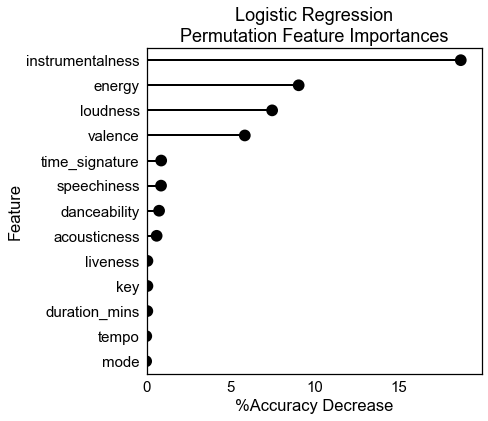

In [16]:
p = permutation_importance_plot(best_logistic, X, y, 
                                model_name='Logistic Regression')

We can see that the permutation importances for `'instrumentalness'`, `'energy'`, and `'valence'` are similar to their corresponding logistic regression coefficients. `'loudness'`, however, has a *large permutation importance*, despite a *very small regression coefficient*. Similarly, `'speechiness'` had a *large regression coefficient*, but has a *very small permuatation importance*. As discussed earlier, the logistic regression coefficients are very sensitive to each feature's standard deviation. Let's have a look at the standard deviation of the features in question: 

In [4]:
cols = ['instrumentalness', 'energy', 'loudness', 'valence', 'speechiness']
df[cols].std()

instrumentalness    0.373226
energy              0.247617
loudness            5.325505
valence             0.284330
speechiness         0.105973
dtype: float64

We can see that the variables whose regression coefficients and permutation importances are similar have a standard deviation of around `0.3`. `'loudness'` has a *much* larger standard deviation of around `5`, thus contributing to a small regression coefficient. Similarly, `'speechiness'` has a relatively small standard deviation of around `.1`, which led to an inflated regression coefficient.

---

We can conclude from these feature importances that the most important features to our logistic regression model are `'instrumentalness'`, `'energy'`, `'loudness'`, and `'valence'` &mdash; in that order. Recalling the sign of the corresponding logistic regression coefficients, we can conclude that **most of the logistic regression model's accuracy comes from selecting tracks that are *more instrumental*, *higher in energy*, *lower in valence*, and *less loud***.

## Decision Tree

For our first *nonlinear* model, let's build a simple *decision tree* classifier. This serves as a segue to the more complex ensembles of trees that we'll use later. It is also still quite interpretable.

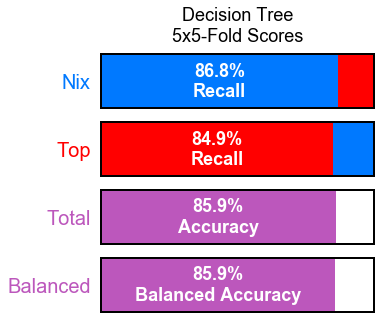

In [12]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X, y)

p = model_score_plot(tree, X, y, model_name='Decision Tree')

#86% balacc

It might be surprising to see that this nonlinear model has lower scores across the board than our logistic regression model, but this speaks to the strengths of reporting *cross-validated* scores. Since we are using a full-depth decision tree, the tree is overfitting to the training sets, thus giving suboptimal performance on the validation sets. We could build a tree with *much* better generalization scores by e.g. restricting the tree depth, and determining an appropriate depth via e.g. a cross-validated grid search. I'll leave that to the reader, as we will soon be moving to much more powerful ensembles of trees.

---

Despite overfitting, the decision tree's parameters are very useful and interpretable. Let's see how our decision tree splits the data by visualizing the first few layers. We'll start with one of scikit-learn's built-in plotting functions, and customize it to visualize purity with a diverging red-blue color scheme. **Blue** indicates purely `'nix'` tracks, **red** indicates purely `'top'` tracks, and **white** indicates a perfectly "impure" balance of tracks from both datasets.

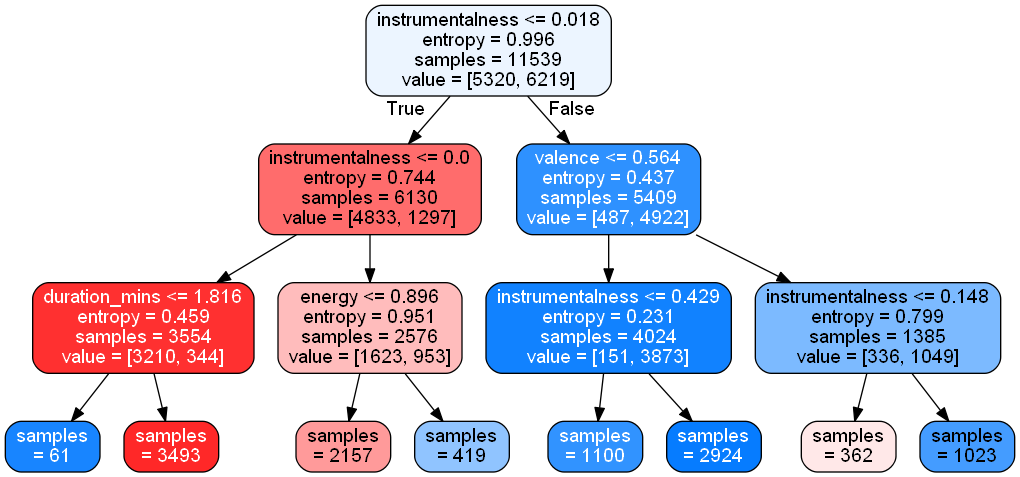

In [55]:
#Note: This is modified to generate a png rather than standard 
#sklearn graph output so it will persist between notebook runs.

#Build depth 3 graph to pull data for coloring leaf nodes
dot_data = export_graphviz(tree, max_depth=3, out_file=None, filled=True, 
                           feature_names=X.columns, rounded=True) 
graph = pydotplus.graph_from_dot_data(dot_data)
nodes = graph.get_node_list()
#Remove leaf nodes from this larger tree.
nodes = [node for node in nodes if node.get_label() != '\"(...)\"']

#Build depth 2 graph for plotting
dot_data2 = export_graphviz(tree, max_depth=2, out_file=None, filled=True, 
                           feature_names=X.columns, rounded=True) 
graph2 = pydotplus.graph_from_dot_data(dot_data2)
nodes2 = graph2.get_node_list()

#Diverging red-white-blue colormap
color_list=[red,(1,1,1),blue]
cmap = mpl.colors.LinearSegmentedColormap.from_list('mymap', color_list, 
                                                        N=256, gamma=1.0)

#Color nodes and add sample labels to leaf nodes
for (node,node2) in zip(nodes,nodes2):
    
    #Colorization
    if node.get_label():
        #Could also do this with regex
        values = [int(ii) for ii in node.get_label().split(
            'value = [')[1].split(']')[0].split(',')]
        
        #Dataset ratio
        ratio = values[1]/(values[0]+values[1])
        
        #White text on "pure" nodes
        if ratio<.1 or ratio>.9:
            node2.set_fontcolor('#FFFFFF')
        
        #Pull cmap color corresponding to ratio. Convert to int format
        r,g,b,a = [ int(255*c) for c in cmap(ratio) ]
        
        #Convert to hex string and set color.
        color = '#{:02x}{:02x}{:02x}'.format(r,g,b)
        node2.set_fillcolor(color)
    
    #Leaf labels
    if node2.get_label() == '\"(...)\"':
        samples_string = node.get_label().split('samples = ')[1].split('\\n')[0]
        node2.set_label('samples\n= '+samples_string)

        
png_str = graph2.create_png(prog='dot')
p = Image(png_str)
display(p)

With the `criterion='entropy'` flag set, at each level our decision tree splits the datapoints along a single feature in such a way that minimizes the (weighted) average [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory%29) of the two subsets. This is commonly described in terms of mutual information or information gain, but I find it simpler to simply state that it attempts to create subsets that are as "pure" as possible, and that purity is measured as Shannon entropy. A common alternative measure of purity is the [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity), which is nearly identical to entropy mathematically, but is less amenable to theoretical understanding since Shannon entropy is tied to the larger mathematical framework of [information theory](https://en.wikipedia.org/wiki/Information_theory).

We can see that the tree initially splits the tracks into a roughly equal number of *extremely low instrumentalness tracks* and *moderately low to high instrumentalness tracks*. This split alone decreases the entropy significantly from around **1 bit**, to around **0.74 bits** for extremely low instrumentalness tracks, and around **0.44 bits** for moderately low to high instrumentalness tracks. In terms of *ratios* of tracks from each dataset, this is equivalent to dropping from a roughly **even ratio** of tracks, to ratios of roughly **4:1** (extremely low instrumentalness tracks) and **1:10** (moderately low to high instrumentalness tracks). 

The tree then splits the extremely low instrumentalness tracks into *tracks with precisely zero instrumentalness* and *tracks with extremely low (but nonzero) instrumentalness*. it also splits the moderately-low-to-high-instrumentalness tracks into tracks with low or high valence. Note that an individual child node may actually have a *larger* entropy than its parent node, but only when its sibling node has a low entropy and contains more datapoints. The *weighted average* of the two children nodes' entropy must be lower than the parent node's entropy.

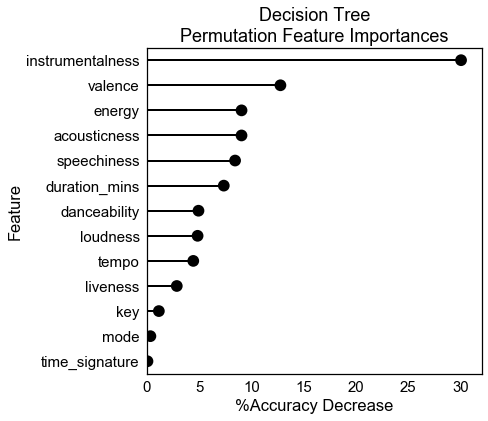

In [19]:
p = permutation_importance_plot(tree, X, y, model_name='Decision Tree')

These importances look similar to those of our logistic regression model. The decision tree makes even more use of `'instrumentalness'` and `'valence'`, but is now able to utilize `'acousticness'`, `'speechiness'`, and `'duration_mins'`, all of which exhibit the behavior discusssed earlier, i.e. having similar *means* across datasets, but more *extreme* tracks coming from my library &mdash; a pattern that can only be effectively exploited by a nonlinear classifier. The decision tree is also able to slightly utilize `'danceability'`, `'tempo'` and `'liveness'`, but `'key'`, `'mode'`, and `'time_signature'` still contribute very little to classification.

## Random Forest

Now we're ready to try some much more powerful models, while sacrificing some interpretablity. First, we'll fit a *random forest* model to our datasets. 

As discussed above, a full-depth decision tree is a very [high-variance ("strong learner"), low-bias](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) model that will typically overfit to its training set. To reduce such overfitting, we would like to decrease the variance of the model while also keeping the bias low. We can do so by using a number of different techniques (e.g. simply restricting a tree's depth), but such methods ultimately need to be tested empirically. A method that has been found to perform very well on a broad range of datasets is the [**random forest**](https://en.wikipedia.org/wiki/Random_forest) method. This algorithm fits a large number of deep decision trees on [boostrapped](https://en.wikipedia.org/wiki/Bootstrapping_(statistics%29) samples from the training set, and selects only a random subset of features to consider when performing each split. Each tree will therefore overfit to a different random, impoverised subset of the data. The trees then vote together on predictions, thus averaging out these overfits. Since the trees are trained and perform predictions in parallel, the random forest method is also highly parallelizable.

I performed minimal tweaking of the forest's hyperparameters using a cross-validated grid search &mdash; mostly testing small deviations from the defaults. The best model found used `criterion='entropy'`, with the remaining hyperparameters set to their defaults. I started with 1000 trees and reduced the number of trees until it affected the scores significantly. 100 trees appears to be sufficient for our purposes.

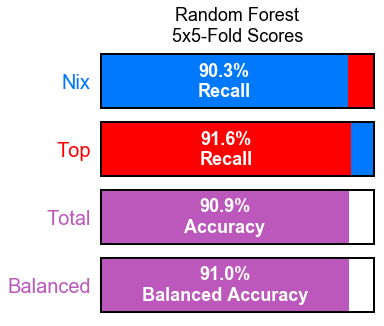

In [16]:
#Hyperparameters chosen from commented-out grid search below. 
#Uncomment to perform your own search.
best_rf = RandomForestClassifier(n_jobs=-1, n_estimators=100, 
                                 criterion='entropy')
best_rf.fit(X, y)

# # Parameter values to test. Only testing slight deviations from defaults.
# param_grid = { 'min_samples_split' : [2, 4],
#                'min_samples_leaf' : [1, 2],
#                'max_features': ['auto', None],
#                'criterion': ['gini', 'entropy'] }
# #Best parameters : {'criterion': 'entropy', 'max_features': 'auto', 
# #'min_samples_leaf': 1, 'min_samples_split': 2}

# model_class = RandomForestClassifier(n_jobs=-1, n_estimators=100)
# best_rf = rskfold_gridsearch(X, y, model_class, param_grid)

p = model_score_plot(best_rf, X, y, model_name='Random Forest')

#91% balacc, 140secs

The random forest gives us a $3.5\%$ increase in balanced accuracy, compared to our previous best model (logistic regression). This is a reduction in error rate of around $1 - \frac{1-0.91}{1-0.885} \approx 22\%$.

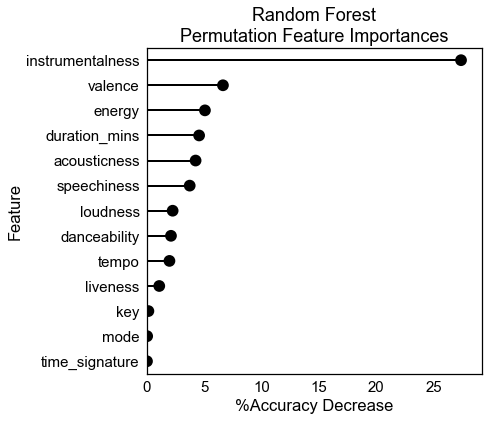

In [10]:
p = permutation_importance_plot(best_rf, X, y, model_name='Random Forest')

The random forest's permutation importances are nearly identical to that of the decision tree, which is perhaps unsurprising since the random forest is simply an ensemble of such trees. It does appear that this model gives even greater relative importance to `'instrumentalness'` than our previous models did.

## Boosted Trees (LightGBM)

Next we'll use a [boosted](https://en.wikipedia.org/wiki/Boosting_(machine_learning%29) trees model, specifically Microsoft's efficient [LightGBM](https://github.com/Microsoft/LightGBM) implementation of [gradient boosted](https://en.wikipedia.org/wiki/Gradient_boosting) decision trees. 

Recall that the random forest method combines many *strong learners* (high-variance, deep decision trees) in a way that produces an ensemble model with *less variance* while maintaining a *low bias*. **Boosted trees** is a method for combining many *weak learners* (low-variance, *shallow* decision trees) in a way that produces an ensemble model with *less bias* while maintaining a *low variance*.

Tree boosting strengthens these weak learners by iteratively training each tree on what was "missed" by the ensemble of previously trained trees, and then incorporating that tree into the ensemble. Some methods will simply weight datapoints that were misclassified by the ensemble more heavily, and train the new tree on these weighted datapoints. Other methods calculate a residual between the ensemble's predictions and the true labels and train the new tree on this residual. Gradient boosting (such as LightGBM) does the latter.

Note that unlike the random forest method, tree boosting is an inherently *sequential* (non-parallel) method: Each tree in a boosted trees model depends on all of the trees trained before it. Nonetheless, many implementations (such as LightGBM) have managed to make the algorithm parallelizable by parallelizing the construction of *each* tree.

I again tweaked the hyperparameters using a cross-validated grid search, testing simple deviations from the defaults. I initialized the model class with these optimal hyperparameters directly below. As with our random forest model, using more than 100 trees gave very little improvement to scores.

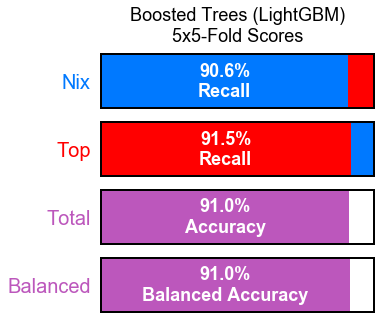

In [8]:
#Hyperparameters chosen from commented-out grid search below. 
#Uncomment to perform your own search.
best_lgbmc = lgb.LGBMClassifier(num_leaves=64, n_estimators=100, max_bin=512,
                               min_child_weight=1e-3, min_child_samples=1, 
                               colsample_bytree=0.75)

best_lgbmc.fit(X, y)

# param_grid = {
#     'learning_rate': [0.05,0.1,0.2],
#     'n_estimators': [100],
#     'num_leaves': [16,32,64],
#     'max_bin': [128,256,512],
#     'min_child_weight': [1e-3,5,25],
#     'min_child_samples' : [1,10,100],
#     'min_split_gain': [0,0.5],
#     'colsample_bytree': [.5,.75,1]}
#best {'colsample_bytree': 0.75, 'learning_rate': 0.1, 'max_bin': 512, 
#'min_child_samples': 1, 'min_child_weight': 0.001, 'min_split_gain': 0, 
#'n_estimators': 100, 'num_leaves': 64}

# param_grid = {
#     'n_estimators': [100],
#     'num_leaves': [64, 128],
#     'max_bin': [512,1024],
#     'min_child_weight': [1e-3,5],
#     'min_child_samples' : [1,10]}
#best {'max_bin': 512, 
#'min_child_samples': 1, 'min_child_weight': 0.001, 
#'n_estimators': 100, 'num_leaves': 64}

# model_class = lgb.LGBMClassifier()
# best_lgbmc = rskfold_gridsearch(X, y, model_class, param_grid)

p = model_score_plot(best_lgbmc, X, y, model_name='Boosted Trees (LightGBM)')
#91% balacc, 9secs

We see nearly identical performance to that of our random forest model (sometimes slightly better), and the LightGBM model is faster and more memory efficient, both to train and to run.

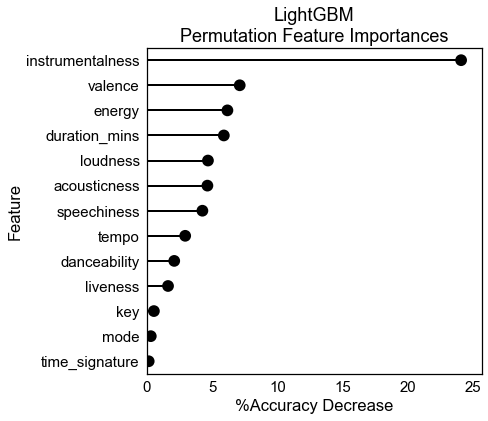

In [38]:
p = permutation_importance_plot(best_lgbmc, X, y, model_name='LightGBM')

Again these feature importances look nearly identical to those of our random forests model, as well as our decision tree model.

---

Since our LightGBM model gives the best scores (tied with or barely exceeding those of our random forest model), while also being more time and memory efficient, we'll use this model as our gold-standard classifier for the remainder of this project.

## Including Non-audio Features

Recall that the 91% balanced accuracy that we've acheived thus far was the result of utilizing *only audio features* in our predictions. Adding in cultural features and metadata (like popularity and release dates) may give higher accuracy, but would deviate from the goals of this project. Again, we want to see how well we can classify a track using *only* the track's audio, and specifically using only the audio features that Spotify has calculated for us. 

Just to give some perspective, let's see how our scores would increase if we allowed our model to utilize *all* of the numerical features available to us. We'll simply re-use the optimal hyperparameters that we found above.

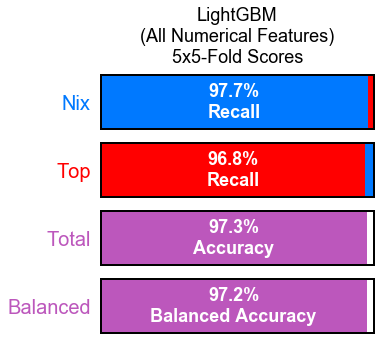

In [39]:
cols_numer = ['acousticness', 'danceability', 'disc_number', 'duration_mins', 
        'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 
        'loudness', 'mode', 'num_followers', 'popularity', 'popularity_album', 
        'popularity_artist', 'release_year', 'speechiness', 'tempo', 
        'time_signature', 'track_number', 'valence']

X2,y2 = df_to_Xy(df,cols_numer)

best_lgbmc2 = lgb.LGBMClassifier(num_leaves=64, n_estimators=100, max_bin=512,
                                min_child_weight=1e-3, min_child_samples=1, 
                                colsample_bytree=0.75)
best_lgbmc2.fit(X2, y2)

p = model_score_plot(best_lgbmc2, X2, y2, 
                 model_name='LightGBM\n(All Numerical Features)')
#97% balacc

#actually an underestimate since would get better if did grid search on these
#full features

By including non-audio features in our boosted trees model, we've increased our balanced accuracy by $6.2\%$, which is a reduction in error rate of $1 - \frac{1-0.972}{1-0.91} \approx 69\%$!

**Note:** Since we re-used our optimal hyperparameters from before, we would expect *even higher* scores were we to perform hyperparameter optimization again with these additional features available to the model class.

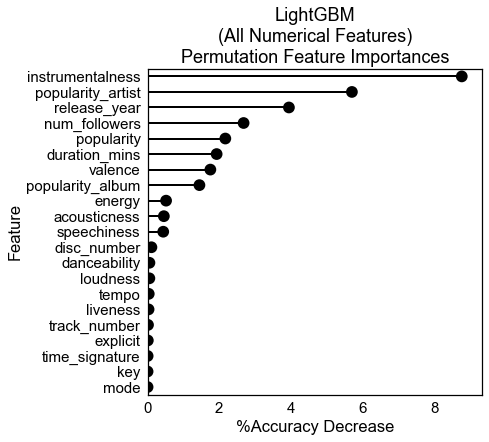

In [40]:
p = permutation_importance_plot(best_lgbmc2, X2, y2, 
                        model_name='LightGBM\n(All Numerical Features)')

We can see that `'instrumentalness'` still contributes the most to prediction, but the model now makes heavy use of popularity features (`'popularity_artist'`, `'num_followers'`, `'popularity'`, `'popularity_album'`), as well as the track's `'release_year'`. 

While utilizing popularity features gives a clear improvement to performance scores, it might lead to undesirable results e.g. when using it to suggest tracks that I might enjoy. Tracks from my library are naturally less popular than those from the top Billboard hits, so predicting based on popularity will cause the model to recommend tracks to me *simply because they are unpopular*. This is an example of overfitting that even cross-validation can't help us avoid.

Suggesting tracks based (partly) on `'release_year'` might be more reasonable, as it could isolate certain genres and eras of music. However, it is still not in the spirit of our audio-focused approach.

## Misclassified Tracks (LightGBM)

Before moving on to building our track recommender, lets see what kinds of tracks our model fails to correctly classify. We'll use the model's `predict_proba` method to determine the model's predicted probability that a given track came from my library (`'nix'`). We'll then compare that with the true dataset to obtain a measure of classification error rate for that track. For example, if the true dataset is `'nix'`, and the predicted probability of the track coming from `'nix'` is 0.25, there's a 75% chance of misclassification. With a classification threshold of `0.5`, a track will be misclassified when this error rate is above 0.5.

In [30]:
cols = ['acousticness', 'danceability', 'duration_mins', 'energy', 
              'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
              'speechiness', 'tempo', 'time_signature', 'valence']

df_temp = df.dropna(subset=cols).copy()

df_temp_X = df_temp[cols]

#Predict probability of being in each dataset
y_pred = best_lgbmc.predict_proba(df_temp_X)

#New column is probability that the track belongs in my dataset.
df_temp['prob_nix'] = y_pred[:,1]

#Colums to display
cols = ['name_artist', 'name', 'instrumentalness', 'valence', 
        'prob_nix', 'ds', 'error_rate']

#Encode dataset variable, and calculate error rate
mapping = {'nix':1,'top':0}
df_temp['error_rate'] = ( df_temp['ds'].map(mapping) - 
                         df_temp['prob_nix'] ).abs()

#Create and show the 10 tracks with highest error_rate
df_temp_head = df_temp.sort_values(by='error_rate', 
                                   ascending=False)[cols].head(10)
df_temp_head

,name_artist,name,instrumentalness,valence,prob_nix,ds,error_rate
4330,Paula Abdul,Cold Hearted,0.008710,0.724,0.237510,nix,0.762490
4218,Oingo Boingo,Wake Up (It's 1984),0.000093,0.759,0.289272,nix,0.710728
2144,Dr. Dre,"Nuthin' But A ""G"" Thang",0.000000,0.654,0.297800,nix,0.702200
3109,La Roux,Bulletproof,0.000046,0.696,0.308461,nix,0.691539
9149,Prince,Let's Go Crazy,0.002200,0.376,0.672032,top,0.672032
2442,Gary Numan,Bombers ('79 Live Original Mix),0.004530,0.943,0.349761,nix,0.650239
5145,Soft Cell,Where Did Our Love Go? - Non Stop Ecstatic Dan...,0.001760,0.842,0.365654,nix,0.634346
1926,Devo,"""37""",0.001500,0.590,0.381626,nix,0.618374
2475,Gary Numan,Remind Me to Smile,0.002370,0.794,0.382268,nix,0.617732
5601,Tubeway Army,Every Day I Die,0.007210,0.942,0.387095,nix,0.612905


Some of these tracks are found in both datasets, which explains our model's confusion. Let's have a look at what datasets these tracks come from:

In [31]:
#Technically, should group by track ID, but there is no ambiguity in our case
df[ df.name.isin(df_temp_head.name) ].groupby('name').ds.unique()

name
"37"                                                               [nix]
Bombers ('79 Live Original Mix)                                    [nix]
Bulletproof                                                   [nix, top]
Cold Hearted                                                  [nix, top]
Every Day I Die                                                    [nix]
Let's Go Crazy                                                [nix, top]
Nuthin' But A "G" Thang                                       [nix, top]
Remind Me to Smile                                                 [nix]
Wake Up (It's 1984)                                                [nix]
Where Did Our Love Go? - Non Stop Ecstatic Dancing Version         [nix]
Name: ds, dtype: object

We can see that *Bulletproof*, *Cold Hearted*, *Let's Go Crazy*, and *Nuthin' but a "G" Thang* are present in both datasets. 

The remaining misclassified tracks are all from my dataset, and are from artists Gary Numan, DEVO, Oingo Boingo, and Soft Cell. These are all New Wave, Synth Pop, and Post Punk artists from the 70s-80s. This is a cluster of genres that I enjoy, but which are atypical in my dataset as they have vocals (low instrumentalness) while also having higher valence (as found in my [previous notebook](spotify_3_audio_features.ipynb)). It therefore makes sense that our classifier would have trouble with these seemingly atypical (given my tastes) tracks.

# Track Recommender (LightGBM)

To finish up this part of the project, let's use our LightGBM classifier to build a novel track recommender. This recommender will gather a variety of tracks from Spotify and filter out all but those with a high probability of "belonging" in my dataset, according to our LightGBM classifier.

A couple of caveats:
- Technically, our classifier was not trained to distinguish between tracks that I like or dislike. Rather, it is able to distinguish between tracks that I like and *top Billboard hits*. When using this classifier for recommendations, we're effectively assuming that the Billboard hits dataset functions as a *baseline* of "typical," popular music. In practice, this assumption does lead to a good recommender for my particular library and tastes. It does, however, emphasize tracks that are particularly un-poppy or less "accessible," as those are the most distinguishable from Billboard hits.

- We're going to build a *single-user* track recommender. This recommender is not a "[recommender system](https://en.wikipedia.org/wiki/Recommender_system)" in the typical sense, as recommender systems are intended to work for a large number of users, and to do so efficiently. It may be impractical to train a complex classifier for each user, especially if it needs to be retrained whenever the user adds more tracks to their library.

- Since we'll be using the Spotify API's track recommendation functionality to generate novel tracks, it may appear that the API is doing most of the recommending for us. However, we'll only be providing the API with *random selections of artists* from *both* datasets in an attempt to gather a large variety of tracks. These tracks *will* be somewhat similar to tracks from our combined (`'nix'` and `'top'`) dataset, but the classifier will do the rest of the work to decide how much I might like each track. In fact, even Spotify's most advanced, personalized recommendations (e.g. it's Discover Weekly playlist) have a *lot* of false positives in my experience, and I've found that the classifier works quite well as a second stage of filtering (and sorting).

## Authorization, Novel Track Scraping, and Filtering Functions

As a first step, we need to obtain a Spotify API authorization token. We'll do so by using our `spotify_auth` function that we defined in our [previous notebook on Spotify scraping](spotify_1_scraping.ipynb). Make sure to include valid API keys either here, in `keys.py`, or in `secret_keys.py`.

In [4]:
#Run in console if notebook fails to provide input() prompt.
auth_dict = { 'client_id' : client_id,
              'secret' : secret,
              'redirect_uri' : redirect_uri,
              'scope' : 'playlist-modify-private',
              'username' : username }

sp = spotify_auth( auth_dict )

Successfully received auth token.


In our scraping notebook, we also defined a number of functions for scraping a playlist's tracks and wrangling and merging the tracks' features into a single usable pandas dataframe. Here, we'll utilize some of those functions to build similar dataframes of tracks pulled from the Spotify API's track recommendation functionality:

- `scrape_recommendations_raw` takes a list of `seed_artists` and passes them to the Spotify API's track recommender. It takes the resulting tracks and pulls in audio features, artist information, and album information using three separate API calls. The function then returns these tracks and features as separate arrays.

- `scrape_recommendations_dataframe` builds upon `scrape_recommendations_raw` to merge these tracks and features into a single dataframe.

In [9]:
def scrape_recommendations_raw(sp, seed_artists, limit=20):
    
    #Scrape tracks
    results = sp.recommendations(seed_artists=seed_artists, limit=limit)
    
    tracks = results['tracks']
    
    results_ids = [ x['id'] for x in tracks ]
    features = sp.audio_features( results_ids )
    
    #This only pulls first artist id per track for now.
    results_ids_artist = [ x['artists'][0]['id'] for x in tracks ] 
    artists = sp.artists( results_ids_artist )['artists']
    results_ids_album = [ x['album']['id'] for x in tracks ]
    albums = sp.albums( results_ids_album )['albums']
    
    return tracks, features, artists, albums


def scrape_recommendations_dataframe(sp, seed_artists, limit=20):
    
    #Scrape tracks, features, artists, albums as lists, derive ids
    tracks, features, artists, albums = scrape_recommendations_raw(sp, 
                                                                  seed_artists,
                                                                  limit=limit)
    ids = [ x['id'] for x in tracks ]
    
    #Build tracks and features dataframes
    df_tracks = tracks_dataframe(tracks)
    df_features = features_dataframe(features, ids)
    df_artists = artists_dataframe(artists)
    df_albums = albums_dataframe(albums)
    
    #Join into one dataframe
    df = df_tracks.join(df_features).join(df_artists, rsuffix='_artist').join(
        df_albums, rsuffix='_album')
    
    return df

With our main scraping functions defined, we now need to construct a list of seed artists and use them to generate novel tracks. We then need to determine the probability of them belonging in my library, and return them as a dataframe, sorted by said probability. To this end, we construct the following functions:

- `get_seed_artists` constructs a list of seed artist ids by randomly sampling tracks from our datasets (an equal number from each dataset) and storing the corresponding artists. Artists with more tracks in our datasets will therefore appear more frequently in our list of seed artists. We'll generate enough artist ids that we can use the maximum of 5 seeds per API request, with `numreq_max` determining the maximum number of such requests. Once enough seed artist ids have been sampled from the two datasets, they're concatenated and shuffled together. The function then returns the artist ids in sets of 5.

- `get_novel_tracks` takes such sets of seed artist ids and pulls recommended tracks using the Spotify API. The number of tracks pulled per request is determined by `numres_per_req`, and the function will continue to perform requests until at least `numtracks_min` novel tracks are gathered. As tracks are pulled, tracks that have already been gathered will be discarded, as will tracks by artists in the current lists of seed artists (to encourage more variety). In addition, any tracks that are already in our datasets will also be discarded. The total set of recommended tracks and their features is then returned as a pandas dataframe.

- `predict_sort_tracks` takes a dataframe of tracks and a classifier, and uses said classifier's `predict_proba` method to determine the probability that I'll like a given track. It then sorts the dataframe by these probabilities and returns it, with the probabilities as a new column.

- `get_ranked_tracks` combines the above functions to generate seed artists, use them to pull recommendations, and sort them by the probability that I'll like them.

In [102]:
def get_seed_artists(df, numreq_max=50):
    
    #Using the maximum number of seed artists per request (5).
    numseeds = numreq_max*5
    
    #Sample an equal number of tracks from each dataset (rounding up)
    #Pull the corresponding artist ids.
    numseeds_half = int( np.ceil(numseeds/2) )
    ids_nix = df[df.ds=='nix'].sample( numseeds_half ).id_artist.values
    ids_top = df[df.ds=='top'].sample( numseeds_half ).id_artist.values
    
    #Concatenate these artist ids and shuffle them together.
    ids = np.concatenate([ids_nix, ids_top])
    np.random.shuffle(ids)
    ids = ids[:numseeds] #np.split needs exactly numseeds tracks
    
    #Split ids into sets of 5 (numreq_max total sets).
    return np.split(ids, numreq_max)


def get_novel_tracks(sp, ids_split, numtracks_min=100, numres_per_req_max=20, 
                        forbidden_tracks=None):
    
    if forbidden_tracks is None:
        forbidden_tracks = []
    
    df_novel = pd.DataFrame()
    for ids in ids_split:
        #Scrape candidate tracks into a dataframe
        df_cand = scrape_recommendations_dataframe( sp, list(ids), 
                                                  limit=numres_per_req_max )

        #The API tends to recommend tracks by the same artists that we seed with
        #remove those to encourage more 'spread'.
        df_cand = df_cand[ ~df_cand.id_artist.isin( list(ids) ) ]
        
        #Remove tracks present in forbidden_tracks (typically our training set)
        df_cand = df_cand[ ~df_cand.id.isin( forbidden_tracks ) ]
        
        #Add remaining candidates to our novel tracks, and drop duplicates
        df_novel = pd.concat([df_novel, df_cand]).drop_duplicates(subset='id')

        #Stop when enough novel tracks have been obtained
        if len(df_novel)>=numtracks_min:
            break

    #Remove unused columns
    cols = ['available_markets','preview_url','images','images_album']
    df_novel.drop(cols, axis=1, inplace=True)

    return df_novel


def predict_sort_tracks(tracks, model, cols):

    #Restrict track columns to those used by model
    df_temp = tracks.dropna(subset=cols).copy()
    df_temp_X = df_temp[cols]

    #Predict probability of being in target dataset, assign values to new 
    #column.
    y_pred = model.predict_proba(df_temp_X)
    df_temp['prob_target'] = y_pred[:,1]

    #Sort tracks by prob_target, reset index
    df_temp = df_temp.sort_values(by='prob_target', ascending=False)
    df_temp.reset_index(drop=True, inplace=True)
    
    return df_temp


def get_ranked_tracks(sp, df, model, cols, numtracks_min=100, numreq_max=50,
                               numres_per_req_max=20):
    """Generates a dataframe of novel tracks, sorted by predicted
    probability of being in target dataset.
    
    Args:
        sp: Spotify API object.
        df: Dataframe of potential seed tracks.
        model: Scikit-learn classifier model.
        cols: Columns used by model.
        numtracks_min: Minimum number of novel tracks returned.
        numreq_max: Maximum number of Spotify API requests to send (total).
        numres_per_req_max: Results to return *per request*.
    """
    
    #Get seed artists
    ids_split = get_seed_artists(df, numreq_max=numreq_max)
    
    #Forbidden tracks are those that are already in original dataframe
    forbidden_tracks = df.id.values
    
    #Get novel tracks
    tracks = get_novel_tracks(sp, ids_split, numtracks_min=numtracks_min, 
                              numres_per_req_max=numres_per_req_max, 
                              forbidden_tracks=forbidden_tracks)
    
    #Predict and sort by probability of being in target dataset
    df_rec = predict_sort_tracks(tracks, model, cols)
    
    return df_rec

## Recommending Tracks

With our functions defined, we're ready to recommend some tracks!

In [2]:
# #Uncomment the following text to re-scrape. Otherwise, simply load from hdf
# #Features used by our classifier
# cols = ['acousticness', 'danceability', 'duration_mins', 'energy', 
#               'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
#               'speechiness', 'tempo', 'time_signature', 'valence']

# df_rec = get_ranked_tracks(sp, df, best_lgbmc, cols, numtracks_min=1000)
# df_rec.to_hdf('./data/df_rec.h5', 'main')
df_rec = pd.read_hdf('./data/df_rec.h5', 'main')

Let's see our list of novel tracks, sorted by probability of belonging in my library:

In [8]:
#Most recommended 
cols = ['name_artist', 'name', 'prob_target']
df_rec[cols].head(10)

,name_artist,name,prob_target
0,Watain,Malfeitor,0.999806
1,Belphegor,Apophis - Black Dragon,0.999737
2,Andy Stott,Time Away,0.999726
3,Essaie Pas,New Path,0.999669
4,Austin Wintory,Heaven Was Not Named,0.999630
5,Tim Hecker,Live Room Out,0.999559
6,Dark Funeral,As One We Shall Conquer,0.999556
7,3TEETH,Away from Me,0.999480
8,FabrikC,Hexenjagd (Club Mix),0.999468
9,Chainreactor,Over the Line,0.999444


In [111]:
#Least recommended 
df_rec[cols].tail(10)

,name_artist,name,prob_target
306,Mike & The Mechanics,The Living Years,0.003655
307,Lil Baby,My Dawg,0.003650
308,Jay Sean,Make My Love Go,0.003208
309,Gyptian,Beautiful Lady,0.002901
310,Nelly,Hot In Herre,0.002747
311,Seals and Crofts,I'll Play For You,0.002699
312,Electric Light Orchestra,Telephone Line,0.002241
313,John Mayer,In the Blood,0.002237
314,Xzibit,Alkaholik,0.001836
315,Melissa Manchester,Through the Eyes of Love (Theme from the Motio...,0.001756


At first glance, this appears to have worked quite well! At the top, I see artists that I've been meaning to check out, as well as many unfamiliar tracks from familiar artists. The tracks at the bottom definitely seem less appealing to me, though I see some possible false positives. This is to be expected, and reflects the problem we discussed above with using Billboard hits as "negative" samples.

I'm excited to check out these recommended tracks! Let's write the most recommended tracks to a new Spotify playlist and embed a Spotify player in the notebook.

## Writing to a New Spotify Playlist

Let's create a new (timestamped) playlist, obtain its playlist id, and populate it with tracks that have at least a 99% probability of belonging in my dataset.

In [5]:
#Create playlist
playlist_name = 'LightGBM Recommendations ' + str( np.datetime64('now') )
results = sp.user_playlist_create(username, playlist_name, public=False)
playlist_id = results['id']

#Write most recommended tracks
track_ids = df_rec[ df_rec.prob_target>0.99 ].id.values
results = sp.user_playlist_add_tracks(user=username, playlist_id=playlist_id, 
                                       tracks=track_ids)

Now, let's embed a player and check out our new playlist!

*Note: This may not render properly on some platforms, e.g. GitHub.*

In [2]:
#Hardcoded playlist ID for persistent notebook rendering.
#Comment out to use playlist_id generated above.
playlist_id = '2V2VNpKPMA0KiRM5VJwXif'

html_string = ('<iframe src="https://open.spotify.com/embed?uri=spotify:user:'
            + username + ':playlist:' + playlist_id + '" width="300" '
            + 'height="380" frameborder="0" allowtransparency="true"></iframe>')
display( HTML(html_string) )

## Recommended Genres

To end this section, let's plot the top genres from each dataset along with the top genres from our recommended (and "unrecommended") tracks. We'll use our `groupby_lists` function from our [previous notebook](spotify_2_basic_exploration.ipynb).

I leave thorough analysis of these plots to the reader.

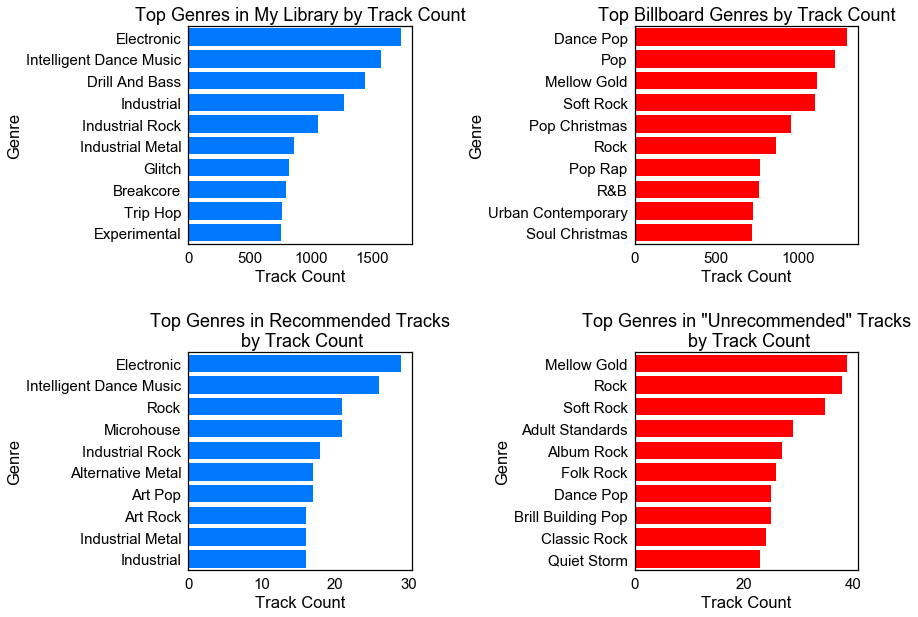

In [12]:
#Add dataset variable to recommendations dataframe, according to where our
#classifier thinks the track "belongs" (by rounding 'prob_target')
mapping = {0:'top',1:'nix'}
df_rec['ds'] = round(df_rec.prob_target).map(mapping)

#Group dataframes by genre
by_genre = groupby_lists(df,'genres','genre')
by_genre_rec = groupby_lists(df_rec,'genres','genre')

#Store genre counts for each dataset
df_temp = by_genre.ds.value_counts().to_frame(name='count').reset_index(
    ).sort_values(by='count', ascending=False)
df_temp_rec = by_genre_rec.ds.value_counts().to_frame(name='count').reset_index(
    ).sort_values(by='count', ascending=False)

fig, ( (ax1,ax2), (ax3,ax4) ) = plt.subplots(2,2,figsize=(12,10))


#Top 10 genres in 'nix' dataset.
df_temp_nix = df_temp[df_temp.ds=='nix'].head(10)

p = sns.barplot(x='count',y='genre',data=df_temp_nix, color=blue, ax=ax1,
               saturation=1)
ax1.set_ylabel('Genre') 
ax1.set_xlabel('Track Count')
ax1.set_title('Top Genres in My Library by Track Count');

#Top 10 genres in 'top' dataset.
df_temp_top = df_temp[df_temp.ds=='top'].head(10)

p = sns.barplot(x='count',y='genre',data=df_temp_top, color=red, ax=ax2,
               saturation=1)
ax2.set_ylabel('Genre') 
ax2.set_xlabel('Track Count')
ax2.set_title('Top Billboard Genres by Track Count')


#Top 10 genres in 'nix' dataset (PREDICTED).
df_temp_rec_nix = df_temp_rec[df_temp_rec.ds=='nix'].head(10)

p = sns.barplot(x='count',y='genre',data=df_temp_rec_nix, color=blue, ax=ax3,
               saturation=1)
ax3.set_ylabel('Genre') 
ax3.set_xlabel('Track Count')
ax3.set_title('Top Genres in Recommended Tracks\n by Track Count');

#Top 10 genres in 'top' dataset (PREDICTED).
df_temp_rec_top = df_temp_rec[df_temp_rec.ds=='top'].head(10)

p = sns.barplot(x='count',y='genre',data=df_temp_rec_top, color=red, ax=ax4,
               saturation=1)
ax4.set_ylabel('Genre') 
ax4.set_xlabel('Track Count')
ax4.set_title('Top Genres in "Unrecommended" Tracks\n by Track Count');

plt.subplots_adjust(wspace=1.0, hspace=0.5)

# End

I hope you've enjoyed exploring these datasets with me. Cheers!

*P.S. Ask me about my **multi-label genre classifier** that didn't make it into this notebook.*

---

< [Part 4: Social Features](spotify_4_popularity_and_followers.ipynb) | [Main](index.ipynb) |